# Introduction 
Using the CalEnviroScreen data set and the affordable housing projects data from Los Angeles Housing and Community Invesment Department, we map where in L.A County is affordable housing being built, and if there is an overlap with the areas of high environmental vulnerability and pollution exposure in the county.

# Getting Ready
we'll bring in all of our libraries that we need and then the Cal Envrio data, census tracts, and our affordable housing data.

## Import libraries 
These libraries help us explore our data and get it on maps

In [95]:
# for basic analysis on our data
import pandas as pd

# so we can analyze geographic data
import geopandas as gpd

# to plot things with plotly
import plotly.express as px
from sodapy import Socrata #NEW import!

# for nice basemaps
import contextily as ctx

# for interactive leaflet mapping
import folium


# to handle thousands of markers
from folium.plugins import MarkerCluster

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px


## LA census tracts

We'll start with our basic geojson [LA Census Trats](http://boundaries.latimes.com/set/census-tracts-2012/) file from the LA Times "Mapping L.A Boundaries" API dataset. This data set contains geometry for "statisical areas defined by the Census Bureau"

In [96]:
# Bring in the LA census tracts 
tracts= gpd.read_file('http://boundaries.latimes.com/1.0/boundary-set/census-tracts-2012/?format=geojson')
tracts.head()

kind  external_id         name  \
0  Census Tract (2012)  06037101110  06037101110   
1  Census Tract (2012)  06037101122  06037101122   
2  Census Tract (2012)  06037101210  06037101210   
3  Census Tract (2012)  06037101220  06037101220   
4  Census Tract (2012)  06037101300  06037101300   

                            slug                                    set  \
0  06037101110-census-tract-2012  /1.0/boundary-set/census-tracts-2012/   
1  06037101122-census-tract-2012  /1.0/boundary-set/census-tracts-2012/   
2  06037101210-census-tract-2012  /1.0/boundary-set/census-tracts-2012/   
3  06037101220-census-tract-2012  /1.0/boundary-set/census-tracts-2012/   
4  06037101300-census-tract-2012  /1.0/boundary-set/census-tracts-2012/   

                                            metadata  \
0  {'INTPTLAT': '+34.2594737', 'NAME': '1011.10',...   
1  {'INTPTLAT': '+34.2677213', 'NAME': '1011.22',...   
2  {'INTPTLAT': '+34.2529724', 'NAME': '1012.10',...   
3  {'INTPTLAT': '+34.2516085', 'NAME': '1012.20',...   
4  {'INTPTLAT': '+34.2487732', 'NAME': '1013', 'I...   

                                   resource_uri  \
0  /1.0/boundary/06037101110-census-tract-2012/   
1  /1.0/boundary/06037101122-census-tract-2012/   
2  /1.0/boundary/06037101210-census-tract-2012/   
3  /1.0/boundary/06037101220-census-tract-2012/   
4  /1.0/boundary/06037101300-census-tract-2012/   

                                            geometry  
0  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...  
1  MULTIPOLYGON (((-118.30333 34.27354, -118.3031...  
2  MULTIPOLYGON (((-118.29945 34.25598, -118.2859...  
3  MULTIPOLYGON (((-118.28592 34.24896, -118.2859...  
4  MULTIPOLYGON (((-118.27247 34.23253, -118.2719...

In [97]:
#let's simplify it to just the columns we need
tracts_trimmed = tracts[['name','geometry']]
tracts_trimmed.head()

name                                           geometry
0  06037101110  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...
1  06037101122  MULTIPOLYGON (((-118.30333 34.27354, -118.3031...
2  06037101210  MULTIPOLYGON (((-118.29945 34.25598, -118.2859...
3  06037101220  MULTIPOLYGON (((-118.28592 34.24896, -118.2859...
4  06037101300  MULTIPOLYGON (((-118.27247 34.23253, -118.2719...

In [98]:
# rename the columns
tracts_trimmed.columns = ['Census Tract','geometry']
tracts_trimmed.head()

Census Tract                                           geometry
0  06037101110  MULTIPOLYGON (((-118.30229 34.25870, -118.3007...
1  06037101122  MULTIPOLYGON (((-118.30333 34.27354, -118.3031...
2  06037101210  MULTIPOLYGON (((-118.29945 34.25598, -118.2859...
3  06037101220  MULTIPOLYGON (((-118.28592 34.24896, -118.2859...
4  06037101300  MULTIPOLYGON (((-118.27247 34.23253, -118.2719...

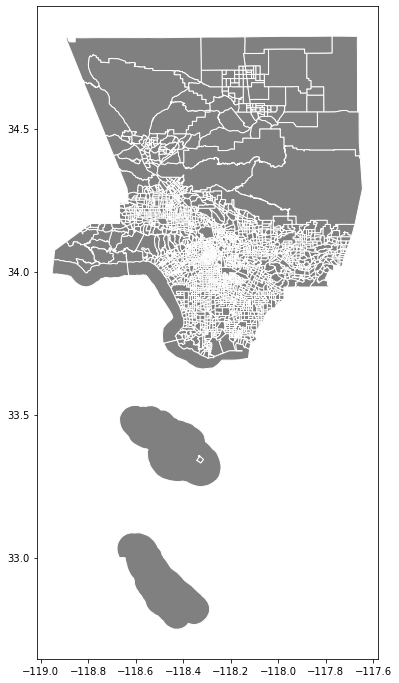

In [99]:
# Look at our map! Added an edge color to our census tracts borders
ax= tracts_trimmed.plot(figsize=(12,12), 
            color='grey', edgecolor='white')




## Cal Enviro data 

This data set includes an index created by the California Environmental Agency and the Office of Environmental Hazard to define areas who have high vulnerability to climate change and are  highly exposed to different types of pollutants. The areas with the highest index scores are designated as “Disadvantaged Communities”, and are used as targeted areas for investments that aim to improve public health, quality of life, and economic opportunity in California. For the purposes of this project we use the term “vulnerable areas” instead of “disadvantaged communities”. The reason is that we do not want to characterize the population or community as "disadvantaged". We assume that the lack of investment in these areas has been a result of zoning and historic racist practices that have resulted in the disproportionate pollution of areas where Black, Indigenous and Brown communities live. 

In [100]:
# import Cal Enviro Screen Data Set
cal_enviro= pd.read_csv('data/CalEnviro_LA_County.csv')

# Look at the first 10 rows to get a sense of what the data is telling us
cal_enviro.head(10)

Census Tract  CalEnviroScreen\n3.0 Score  \
0    6019001100                       94.09   
1    6071001600                       90.68   
2    6019000200                       85.97   
3    6077000801                       82.49   
4    6019001500                       82.03   
5    6037204920                       80.73   
6    6077000300                       80.18   
7    6019001000                       80.13   
8    6037206050                       79.03   
9    6019000400                       78.53   

  CalEnviroScreen 3.0 \nPercentile Range  Pollution Burden\nPercentile  \
0               95-100% (highest scores)                         99.95   
1               95-100% (highest scores)                        100.00   
2               95-100% (highest scores)                         99.00   
3               95-100% (highest scores)                         99.59   
4               95-100% (highest scores)                         99.99   
5               95-100% (highest scores)                         99.88   
6               95-100% (highest scores)                         98.07   
7               95-100% (highest scores)                         97.35   
8               95-100% (highest scores)                         99.90   
9               95-100% (highest scores)                         99.48   

   Population Characteristics\nPercentile  Total Population California County  \
0                                   99.70              3174           Fresno    
1                                   98.11              6133    San Bernardino   
2                                   99.99              3167           Fresno    
3                                   97.72              6692       San Joaquin   
4                                   92.76              2206           Fresno    
5                                   94.89              2598       Los Angeles   
6                                   99.65              2396       San Joaquin   
7                                   99.91              4106           Fresno    
8                                   92.96              2146       Los Angeles   
9                                   95.71              6343           Fresno    

   Approximate Zip Code Nearby City \n(to help approximate location only)  
0                 93706                                            Fresno  
1                 91761                                           Ontario  
2                 93706                                            Fresno  
3                 95203                                          Stockton  
4                 93725                                            Fresno  
5                 90023                                       Los Angeles  
6                 95203                                          Stockton  
7                 93706                                            Fresno  
8                 90023                                       Los Angeles  
9                 93721                                            Fresno

In [101]:
# This changes the census tract column to be imported as a string
cal_enviro['Census Tract'] = cal_enviro['Census Tract'].astype(str)

# And now we add the zero at the begining of the Census Tract Column
cal_enviro['Census Tract'] = cal_enviro['Census Tract'].str.zfill(11)

# Let's take a look to check that it worked
cal_enviro.head(10)

Census Tract  CalEnviroScreen\n3.0 Score  \
0  06019001100                       94.09   
1  06071001600                       90.68   
2  06019000200                       85.97   
3  06077000801                       82.49   
4  06019001500                       82.03   
5  06037204920                       80.73   
6  06077000300                       80.18   
7  06019001000                       80.13   
8  06037206050                       79.03   
9  06019000400                       78.53   

  CalEnviroScreen 3.0 \nPercentile Range  Pollution Burden\nPercentile  \
0               95-100% (highest scores)                         99.95   
1               95-100% (highest scores)                        100.00   
2               95-100% (highest scores)                         99.00   
3               95-100% (highest scores)                         99.59   
4               95-100% (highest scores)                         99.99   
5               95-100% (highest scores)                         99.88   
6               95-100% (highest scores)                         98.07   
7               95-100% (highest scores)                         97.35   
8               95-100% (highest scores)                         99.90   
9               95-100% (highest scores)                         99.48   

   Population Characteristics\nPercentile  Total Population California County  \
0                                   99.70              3174           Fresno    
1                                   98.11              6133    San Bernardino   
2                                   99.99              3167           Fresno    
3                                   97.72              6692       San Joaquin   
4                                   92.76              2206           Fresno    
5                                   94.89              2598       Los Angeles   
6                                   99.65              2396       San Joaquin   
7                                   99.91              4106           Fresno    
8                                   92.96              2146       Los Angeles   
9                                   95.71              6343           Fresno    

   Approximate Zip Code Nearby City \n(to help approximate location only)  
0                 93706                                            Fresno  
1                 91761                                           Ontario  
2                 93706                                            Fresno  
3                 95203                                          Stockton  
4                 93725                                            Fresno  
5                 90023                                       Los Angeles  
6                 95203                                          Stockton  
7                 93706                                            Fresno  
8                 90023                                       Los Angeles  
9                 93721                                            Fresno

In [102]:
# Now we want to just simplify the data to only look at Los Angeles
enviro_LA= cal_enviro[cal_enviro['California County']== 'Los Angeles']

# Let's look at the head to make sure it worked.
enviro_LA.head(10)

Census Tract  CalEnviroScreen\n3.0 Score  \
5   06037204920                       80.73   
8   06037206050                       79.03   
14  06037205120                       78.04   
16  06037291220                       77.50   
20  06037239202                       76.04   
21  06037226002                       76.04   
27  06037535400                       74.46   
31  06037243100                       73.54   
32  06037543305                       73.54   
34  06037204600                       73.13   

   CalEnviroScreen 3.0 \nPercentile Range  Pollution Burden\nPercentile  \
5                95-100% (highest scores)                         99.88   
8                95-100% (highest scores)                         99.90   
14               95-100% (highest scores)                         99.75   
16               95-100% (highest scores)                         99.96   
20               95-100% (highest scores)                         96.91   
21               95-100% (highest scores)                         99.83   
27               95-100% (highest scores)                         97.41   
31               95-100% (highest scores)                         94.35   
32               95-100% (highest scores)                         99.76   
34               95-100% (highest scores)                         98.53   

    Population Characteristics\nPercentile  Total Population  \
5                                    94.89              2598   
8                                    92.96              2146   
14                                   93.44              3618   
16                                   88.16              3353   
20                                   99.23              4724   
21                                   90.38              1604   
27                                   97.96              3495   
31                                   99.68              5350   
32                                   88.26              2666   
34                                   94.83              4101   

   California County  Approximate Zip Code  \
5        Los Angeles                 90023   
8        Los Angeles                 90023   
14       Los Angeles                 90023   
16       Los Angeles                 90247   
20       Los Angeles                 90001   
21       Los Angeles                 90021   
27       Los Angeles                 90002   
31       Los Angeles                 90059   
32       Los Angeles                 90220   
34       Los Angeles                 90023   

   Nearby City \n(to help approximate location only)  
5                                        Los Angeles  
8                                        Los Angeles  
14                                       Los Angeles  
16                                           Gardena  
20                                       Los Angeles  
21                                       Los Angeles  
27                                       Los Angeles  
31                                       Los Angeles  
32                                           Compton  
34                                       Los Angeles

In [103]:
# Let's rename a few of these columns to get the weird \n out of there.
enviro_LA=enviro_LA.rename(columns={"CalEnviroScreen\n3.0 Score": "Score", 
                          "CalEnviroScreen 3.0 \nPercentile Range": "Percentile Range",
                          "Pollution Burden\nPercentile" : "Burden Percentile",
                          "Population Characteristics\nPercentile" : "Characteristcs Percentile",
                          "Total Population" : "Population",
                          "Nearby City \n(to help approximate location only)" : "Nearby City"
                         })

#check out the renamed columns
enviro_LA.head(10)

Census Tract  Score          Percentile Range  Burden Percentile  \
5   06037204920  80.73  95-100% (highest scores)              99.88   
8   06037206050  79.03  95-100% (highest scores)              99.90   
14  06037205120  78.04  95-100% (highest scores)              99.75   
16  06037291220  77.50  95-100% (highest scores)              99.96   
20  06037239202  76.04  95-100% (highest scores)              96.91   
21  06037226002  76.04  95-100% (highest scores)              99.83   
27  06037535400  74.46  95-100% (highest scores)              97.41   
31  06037243100  73.54  95-100% (highest scores)              94.35   
32  06037543305  73.54  95-100% (highest scores)              99.76   
34  06037204600  73.13  95-100% (highest scores)              98.53   

    Characteristcs Percentile  Population California County  \
5                       94.89        2598       Los Angeles   
8                       92.96        2146       Los Angeles   
14                      93.44        3618       Los Angeles   
16                      88.16        3353       Los Angeles   
20                      99.23        4724       Los Angeles   
21                      90.38        1604       Los Angeles   
27                      97.96        3495       Los Angeles   
31                      99.68        5350       Los Angeles   
32                      88.26        2666       Los Angeles   
34                      94.83        4101       Los Angeles   

    Approximate Zip Code  Nearby City  
5                  90023  Los Angeles  
8                  90023  Los Angeles  
14                 90023  Los Angeles  
16                 90247      Gardena  
20                 90001  Los Angeles  
21                 90021  Los Angeles  
27                 90002  Los Angeles  
31                 90059  Los Angeles  
32                 90220      Compton  
34                 90023  Los Angeles

In [104]:
enviro_LA.shape

(1038, 9)

In [105]:
#Columns
list(enviro_LA)

['Census Tract',
 'Score',
 'Percentile Range',
 'Burden Percentile',
 'Characteristcs Percentile',
 'Population',
 'California County',
 'Approximate Zip Code',
 'Nearby City']

## Affordable Housing Data

Now we import the data we will analyze: ["HCIDLA Affordable Housing Projects List (2003 to Present)"](https://data.lacity.org/A-Livable-and-Sustainable-City/HCIDLA-Affordable-Housing-Projects-List-2003-to-Pr/mymu-zi3s)

According to the data description, this data set includes: 
>"HCIDLA financed projects since 2003 to present. These projects are financed with programs including Affordable Housing Managed Pipeline, Supportive Housing Program, Affordable Housing Bond Program, and the Proposition HHH Supportive Housing Loan Program."


In [106]:
# read in a CSV file downloaded from the HCIDLA
hcid=pd.read_csv('data/HCIDLA_AffordableHousing.csv')

# take a look at the first 5 rows to make sure it's 
hcid.head()

APN PROJECT NUMBER                                NAME  \
0  5131020009      05-117217  LEXINGTON APARTMENTS A/B (SITE 11)   
1  5067008008      06-117222        WINDWARD APTS (A/B) (SITE 4)   
2  5108021026      13-120914  JUANITA TATE LEGACY TOWERS (RECAP)   
3  5058024017          20289          LA 78 PRESERVATION PROJECT   
4  2218023009      12-119044      HAZELTINE & WYANDOTTE (SITE 2)   

  DEVELOPMENT STAGE    CONSTRUCTION TYPE  \
0        In-Service                REHAB   
1        In-Service                REHAB   
2        In-Service  ACQUISITION + REHAB   
3        In-Service                  NaN   
4        In-Service  ACQUISITION + REHAB   

                               SITE ADDRESS  SITE  COUNCIL DISTRICT  SITE #  \
0                   1145 E 24TH ST CA 90011                       9      11   
1                 4817 W SATURN ST CA 90019                      10       4   
2         4827 S CENTRAL AVE 1-118 CA 90011                       9       1   
3                   1951 W 22ND ST CA 90018                       8       1   
4  14630 W WYANDOTTE ST  VAN NUYS, CA 91405                       6       2   

    SITE COMMUNITY  SITE UNITS  ...  \
0          CENTRAL           0  ...   
1  ST ELMO VILLAGE           6  ...   
2   VERNON CENTRAL         118  ...   
3       WEST ADAMS          20  ...   
4         VAN NUYS          73  ...   

                                MANAGEMENT COMPANY   CONTACT PHONE  \
0                  ALPHA PROPERTY MANAGEMENT, INC.  (323) 231-4174   
1                  ALPHA PROPERTY MANAGEMENT, INC.  (323) 231-4174   
2  CONCERNED CITIZENS OF SOUTH CENTRAL LOS ANGELES             NaN   
3                        LEONARDO MANAGEMENT, INC.  (602) 350-2931   
4                                 IRONWOOD COMPANY  (818) 789-5550   

                                               PHOTO  JOBS  \
0  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
1  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
2  click here (http://hcidapp.lacity.org/mpphotos...  92.0   
3  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
4  click here (http://hcidapp.lacity.org/mpphotos...  41.0   

                                 PROJECT SUMMARY URL  CONTRACT NUMBERS  \
0  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
1  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
2  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
3  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
4  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   

               DATE STAMP  SITE LONGITUDE SITE LATITUDE  \
0  09/09/2020 12:00:00 AM      -118.25561      34.02133   
1  09/09/2020 12:00:00 AM      -118.34217      34.04429   
2  09/09/2020 12:00:00 AM      -118.25668      33.99978   
3  09/09/2020 12:00:00 AM      -118.30509      34.03651   
4  09/09/2020 12:00:00 AM      -118.45222      34.20289   

                      GPS_COORDS ON MAP  
0  POINT (-118.25561000000002 34.02133)  
1           POINT (-118.34217 34.04429)  
2  POINT (-118.25668 33.99978000000001)  
3  POINT (-118.30509000000002 34.03651)  
4  POINT (-118.45222000000001 34.20289)  

[5 rows x 30 columns]

In [107]:
# List the names of all the columns so we can clean them
hcid_columns = list(hcid) 
hcid_columns

['APN',
 'PROJECT NUMBER',
 'NAME',
 'DEVELOPMENT STAGE',
 'CONSTRUCTION TYPE',
 'SITE ADDRESS',
 'SITE  COUNCIL DISTRICT',
 'SITE #',
 'SITE COMMUNITY',
 'SITE UNITS',
 'PROJECT TOTAL UNITS',
 'HOUSING TYPE',
 'SUPPORTIVE HOUSING',
 'DATE FUNDED',
 'HCIDLA FUNDED',
 'LEVERAGE',
 'TAX EXEMPT CONDUIT BOND',
 'TDC',
 'IN-SERVICE DATE',
 'DEVELOPER',
 'MANAGEMENT COMPANY',
 'CONTACT PHONE',
 'PHOTO',
 'JOBS',
 'PROJECT SUMMARY URL',
 'CONTRACT NUMBERS',
 'DATE STAMP',
 'SITE LONGITUDE',
 'SITE LATITUDE',
 'GPS_COORDS ON MAP']

In [108]:
# Create a trimmed down version of the data using only columns we're interested in
hcid_trim = hcid[[
    'NAME',
    'SITE ADDRESS',
    'SITE COMMUNITY',
    'HOUSING TYPE',
    'SUPPORTIVE HOUSING',
    'SITE LONGITUDE',
    'SITE LATITUDE',
    'DATE FUNDED',
    'IN-SERVICE DATE',
]]
# show a preview of the first 5 rows.
hcid_trim.head()

NAME  \
0  LEXINGTON APARTMENTS A/B (SITE 11)   
1        WINDWARD APTS (A/B) (SITE 4)   
2  JUANITA TATE LEGACY TOWERS (RECAP)   
3          LA 78 PRESERVATION PROJECT   
4      HAZELTINE & WYANDOTTE (SITE 2)   

                               SITE ADDRESS   SITE COMMUNITY HOUSING TYPE  \
0                   1145 E 24TH ST CA 90011          CENTRAL       FAMILY   
1                 4817 W SATURN ST CA 90019  ST ELMO VILLAGE       FAMILY   
2         4827 S CENTRAL AVE 1-118 CA 90011   VERNON CENTRAL      SENIORS   
3                   1951 W 22ND ST CA 90018       WEST ADAMS          NaN   
4  14630 W WYANDOTTE ST  VAN NUYS, CA 91405         VAN NUYS       FAMILY   

  SUPPORTIVE HOUSING  SITE LONGITUDE  SITE LATITUDE DATE FUNDED  \
0                 No      -118.25561       34.02133  12/28/2005   
1                 No      -118.34217       34.04429  04/01/2006   
2                 No      -118.25668       33.99978  12/22/2014   
3                 No      -118.30509       34.03651  12/23/2002   
4                 No      -118.45222       34.20289  12/02/2013   

  IN-SERVICE DATE  
0            2006  
1            2007  
2            2016  
3            2004  
4            2014

# Charting Data

Create a few basic charts to get a look at our data and discover some trends

## Which census tracts have the highest scores?

We took a closer look at the Census Tracts that had the highest environmental vulnerability score. Not surprisingly, the top 10 census tracts are located in the areas in close proximity to freeway intersections in the neighborhood of East Los Angeles, South Los Angeles, and Glendale on the north side.

In [109]:
# Create a figure from the Enviro LA data frame where the score is greater than 73.12 (the top 10)
fig = px.bar(enviro_LA.head(20), 
            x='Census Tract', 
            y='Score', 
            hover_data=['Score'], 
            color='Score',  
            height=500,
            title='Top 20 census tracts with the highest Cal Enviro Screen Scores'
            )

# force the chart to show the census tract as a category <--- THIS IS THE MAGIC TRICK THAT MAKES IT WORK
fig.update_layout(xaxis=dict(type='category'))

fig.show()

## Where is the most affordable housing located in Los Angeles?

We found that the neighborhood of Westlake has the highest number of affordable housing projects financed by HCIDLA with a total of 34 housing projects, followed by the Wholesale District and the Central [district?], which have 23 and 19 projects respectively. Twenty-two site communities only have one housing project built since 2003.


In [110]:
# Now make a data frame that summarizes the number of projects in each community
hcid_community = hcid['SITE COMMUNITY'].value_counts().reset_index()

# Adjust the column headers so the names match the values below
hcid_community.columns = ['Site Community', 'Count']

# Show me the top 20
hcid_community.head(50)

Site Community  Count
0                WESTLAKE     34
1      WHOLESALE DISTRICT     23
2                 CENTRAL     19
3               HOLLYWOOD     17
4         EXPOSITION PARK     16
5          TEMPLE-BEAUDRY     15
6                 MELROSE     14
7         UNIVERSITY PARK     14
8             WEST VERNON     14
9              PICO-UNION     14
10              KOREATOWN     13
11                  WATTS     11
12          VERMONT VISTA     11
13          BOYLE HEIGHTS     10
14             SOUTH PARK     10
15             WEST ADAMS     10
16            NORTH HILLS      9
17     CENTURY PALMS/COVE      9
18          PANORAMA CITY      8
19        WILSHIRE CENTER      8
20         EAST HOLLYWOOD      8
21        LINCOLN HEIGHTS      8
22               VAN NUYS      7
23         VERNON CENTRAL      7
24     FLORENCE-FIRESTONE      7
25               DOWNTOWN      7
26             SILVERLAKE      7
27        HARVARD HEIGHTS      7
28             SUN VALLEY      7
29         HARBOR GATEWAY      7
30      CRENSHAW DISTRICT      6
31        ATWATER VILLAGE      6
32                 SYLMAR      6
33            VALLEY GLEN      5
34              THAI TOWN      5
35                 RESEDA      5
36             WILMINGTON      5
37  HISTORIC FILIPINOTOWN      5
38                PACOIMA      4
39        NORTH HOLLYWOOD      4
40          VICTORIA PARK      4
41          GLASSELL PARK      4
42            CANOGA PARK      3
43              HYDE PARK      3
44                DEL REY      3
45                 VENICE      3
46         VERMONT KNOLLS      3
47              CHINATOWN      3
48      COUNTRY CLUB PARK      2
49          GREEN MEADOWS      2

In [111]:
hcid_community.tail(50)

Site Community  Count
33            VALLEY GLEN      5
34              THAI TOWN      5
35                 RESEDA      5
36             WILMINGTON      5
37  HISTORIC FILIPINOTOWN      5
38                PACOIMA      4
39        NORTH HOLLYWOOD      4
40          VICTORIA PARK      4
41          GLASSELL PARK      4
42            CANOGA PARK      3
43              HYDE PARK      3
44                DEL REY      3
45                 VENICE      3
46         VERMONT KNOLLS      3
47              CHINATOWN      3
48      COUNTRY CLUB PARK      2
49          GREEN MEADOWS      2
50              SAN PEDRO      2
51            HARBOR CITY      2
52          BALDWIN HILLS      2
53              EL SERENO      2
54              ECHO PARK      2
55           LITTLE TOKYO      2
56           HARVARD PARK      2
57        ADAMS-NORMANDIE      2
58       LAKEVIEW TERRACE      2
59          HIGHLAND PARK      2
60      WELLINGTON SQUARE      1
61         JEFFERSON PARK      1
62              MAR VISTA      1
63             EAGLE ROCK      1
64   FIGUEROA PARK SQUARE      1
65              LOS FELIZ      1
66              CRESTVIEW      1
67           HANCOCK PARK      1
68       ANGELINO HEIGHTS      1
69        HOLLYWOOD HILLS      1
70           SHERMAN OAKS      1
71         MT. WASHINGTON      1
72         ELYSIAN VALLEY      1
73       WEST LOS ANGELES      1
74         GRAMERCY PLACE      1
75             EXPOSITION      1
76            RANCHO PARK      1
77                 ALSACE      1
78             CHATSWORTH      1
79        ST ELMO VILLAGE      1
80                SUNLAND      1
81         VERMONT SQUARE      1
82                TUJUNGA      1

In [112]:
# Make a bar graph of communities with more than 6 projects
px.bar(hcid_community[hcid_community['Count'] > 6],
       x='Site Community',
       y='Count',
       title='Top 30 communitities in the City of LA with HCIDLA Affordable Housing Projects',
      )

## What type of housing is being built in each community?
    
The most common types of housing projects built accross all the neighborhoods are family and special needs housing. The latter is housing that directly serves individuals and families with either an intellectual or physical disability, and individuals who are experiencing houselessness, or chronic illness.

In [113]:
hcid_comm_type = hcid[[
 'NAME',
 'SITE COMMUNITY',
 'HOUSING TYPE',
]]

# group by site community and housing type, and let's get a count for each
hcid_grouped=hcid_comm_type.groupby(['SITE COMMUNITY','HOUSING TYPE']).count()[['NAME']]
hcid_grouped.head()

NAME
SITE COMMUNITY   HOUSING TYPE      
ADAMS-NORMANDIE  FAMILY           1
                 SENIORS          1
ALSACE           FAMILY           1
ANGELINO HEIGHTS FAMILY           1
ATWATER VILLAGE  FAMILY           5

In [114]:
# flatten the multi-indexed dataframe
hcid_flat = hcid_grouped.reset_index()
hcid_flat

SITE COMMUNITY   HOUSING TYPE  NAME
0       ADAMS-NORMANDIE         FAMILY     1
1       ADAMS-NORMANDIE        SENIORS     1
2                ALSACE         FAMILY     1
3      ANGELINO HEIGHTS         FAMILY     1
4       ATWATER VILLAGE         FAMILY     5
..                  ...            ...   ...
167  WHOLESALE DISTRICT  SPECIAL NEEDS    17
168          WILMINGTON         FAMILY     3
169          WILMINGTON        SENIORS     2
170     WILSHIRE CENTER         FAMILY     3
171     WILSHIRE CENTER  SPECIAL NEEDS     5

[172 rows x 3 columns]

In [115]:
# make a bar chart
px.bar(hcid_flat,  
       x='SITE COMMUNITY',
       y='NAME',
       color='HOUSING TYPE', # this creates the "stack"
       title='HCIDLA Affordable Housing Projects by Housing Type'
      )

# Merging Data 

Now we start to merge some of our data together, starting with the Cal Enviro Score and the Census Tracts data set that includes the latitude and longitud information, as well as the geographic polygon; which we need in order to create our thematic maps. 

In [116]:
# create a new dataframe based on the join
combined_enviro_tracts=tracts_trimmed.merge(enviro_LA,on="Census Tract")

# show me the first 5 to make sure it worked
combined_enviro_tracts.head()

Census Tract                                           geometry  Score  \
0  06037104103  MULTIPOLYGON (((-118.40085 34.28159, -118.3952...  45.29   
1  06037104108  MULTIPOLYGON (((-118.40853 34.27071, -118.3976...  43.88   
2  06037104203  MULTIPOLYGON (((-118.41799 34.27964, -118.4114...  40.88   
3  06037104204  MULTIPOLYGON (((-118.41142 34.28443, -118.4074...  40.03   
4  06037104310  MULTIPOLYGON (((-118.44011 34.26727, -118.4357...  59.68   

           Percentile Range  Burden Percentile  Characteristcs Percentile  \
0                    80-85%              73.07                      80.78   
1                    80-85%              78.44                      73.25   
2                    75-80%              55.15                      84.56   
3                    75-80%              79.50                      63.83   
4  95-100% (highest scores)              96.63                      81.31   

   Population California County  Approximate Zip Code Nearby City  
0        4085       Los Angeles                 91342      Sylmar  
1        5256       Los Angeles                 91331     Pacoima  
2        5210       Los Angeles                 91331     Pacoima  
3        3375       Los Angeles                 91342      Sylmar  
4        4921       Los Angeles                 91331     Pacoima

In [117]:
# Now let's sort the data 
combined_sorted = combined_enviro_tracts.sort_values(by='Score',ascending = False)

# Take a look at it
combined_sorted.head()

Census Tract                                           geometry  Score  \
221  06037204920  MULTIPOLYGON (((-118.20281 34.01401, -118.2028...  80.73   
227  06037206050  MULTIPOLYGON (((-118.22278 34.01525, -118.2271...  79.03   
223  06037205120  MULTIPOLYGON (((-118.21993 34.01510, -118.2202...  78.04   
458  06037291220  MULTIPOLYGON (((-118.29090 33.87287, -118.2912...  77.50   
409  06037239202  MULTIPOLYGON (((-118.27393 33.98333, -118.2739...  76.04   

             Percentile Range  Burden Percentile  Characteristcs Percentile  \
221  95-100% (highest scores)              99.88                      94.89   
227  95-100% (highest scores)              99.90                      92.96   
223  95-100% (highest scores)              99.75                      93.44   
458  95-100% (highest scores)              99.96                      88.16   
409  95-100% (highest scores)              96.91                      99.23   

     Population California County  Approximate Zip Code  Nearby City  
221        2598       Los Angeles                 90023  Los Angeles  
227        2146       Los Angeles                 90023  Los Angeles  
223        3618       Los Angeles                 90023  Los Angeles  
458        3353       Los Angeles                 90247      Gardena  
409        4724       Los Angeles                 90001  Los Angeles

# Mapping Data

## Cal Enviroscreen Map

First we are mapping all the census tracts that have a CalEnviro index score. We noticed that the majority of census tracts have a score above 40 points. There are a total of 3735 census tracts in L.A County, 1038 or 28 percent of the total were given a score, and are mostly concentrated in L.A City.  
We set the vertical axis legend starting at zero in order to show that there are no census tracts with a score below 40 points. 

In [118]:
# reproject to web mercator
combined_sorted = combined_sorted.to_crs(epsg=3857)

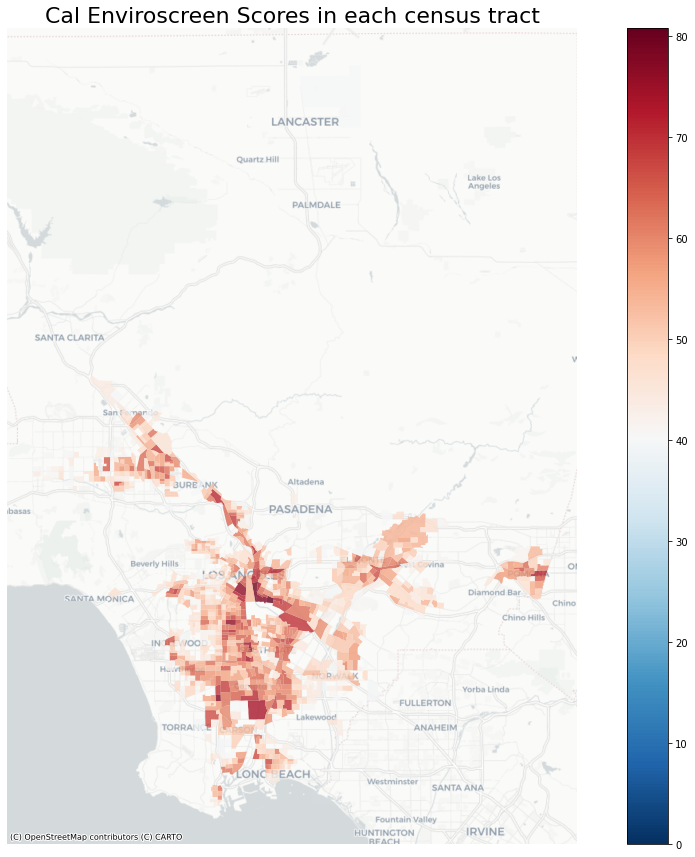

In [119]:
# Now we plot it on a map with a different color gradient
ax = combined_sorted.plot(figsize=(18,15),
                        column='Score',
                        legend=True,
                        alpha=0.8,
                        cmap='RdBu_r',    
                        vmin=0)

ax.axis('off')
ax.set_title('Cal Enviroscreen Scores in each census tract',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Affordable housing map

The Affordable housing scatter plot map displays all affordable housing types funded by HCILDA and built since 2003. 

In [120]:
# there are null values in the Housing Type column, let's fill them out first
hcid['HOUSING TYPE'] = hcid['HOUSING TYPE'].fillna('unknown')

In [121]:
# plot the family housing
fig = px.scatter_mapbox(hcid,
                        lat="SITE LATITUDE",
                        lon="SITE LONGITUDE",
                        hover_name="HOUSING TYPE", 
                        color="HOUSING TYPE",
                        hover_data=["HOUSING TYPE", "SITE ADDRESS"], 
                        mapbox_style="carto-positron",
                        title='Affordable Housing Projects Funded by HCIDLA'
                        )
# show the map
fig.show()

# Creating a Function

Create a function that maps a specific census tract. First we'll work on each piece of it to make sure it works before putting together the complete function


In [122]:
# subset the Cal Enviro geodataframe for a single census tract
singledtract = combined_sorted[combined_sorted['Census Tract']=='06037204920']
singledtract 

Census Tract                                           geometry  Score  \
221  06037204920  MULTIPOLYGON (((-13158276.842 4030683.113, -13...  80.73   

             Percentile Range  Burden Percentile  Characteristcs Percentile  \
221  95-100% (highest scores)              99.88                      94.89   

     Population California County  Approximate Zip Code  Nearby City  
221        2598       Los Angeles                 90023  Los Angeles

In [123]:
# reproject to web mercator
combined_sorted = combined_sorted.to_crs(epsg=3857)

In [124]:
# use the bounding box coordinates to set the x and y limits
minx, miny, maxx, maxy = singledtract.geometry.total_bounds

In [125]:
hcid.head()

APN PROJECT NUMBER                                NAME  \
0  5131020009      05-117217  LEXINGTON APARTMENTS A/B (SITE 11)   
1  5067008008      06-117222        WINDWARD APTS (A/B) (SITE 4)   
2  5108021026      13-120914  JUANITA TATE LEGACY TOWERS (RECAP)   
3  5058024017          20289          LA 78 PRESERVATION PROJECT   
4  2218023009      12-119044      HAZELTINE & WYANDOTTE (SITE 2)   

  DEVELOPMENT STAGE    CONSTRUCTION TYPE  \
0        In-Service                REHAB   
1        In-Service                REHAB   
2        In-Service  ACQUISITION + REHAB   
3        In-Service                  NaN   
4        In-Service  ACQUISITION + REHAB   

                               SITE ADDRESS  SITE  COUNCIL DISTRICT  SITE #  \
0                   1145 E 24TH ST CA 90011                       9      11   
1                 4817 W SATURN ST CA 90019                      10       4   
2         4827 S CENTRAL AVE 1-118 CA 90011                       9       1   
3                   1951 W 22ND ST CA 90018                       8       1   
4  14630 W WYANDOTTE ST  VAN NUYS, CA 91405                       6       2   

    SITE COMMUNITY  SITE UNITS  ...  \
0          CENTRAL           0  ...   
1  ST ELMO VILLAGE           6  ...   
2   VERNON CENTRAL         118  ...   
3       WEST ADAMS          20  ...   
4         VAN NUYS          73  ...   

                                MANAGEMENT COMPANY   CONTACT PHONE  \
0                  ALPHA PROPERTY MANAGEMENT, INC.  (323) 231-4174   
1                  ALPHA PROPERTY MANAGEMENT, INC.  (323) 231-4174   
2  CONCERNED CITIZENS OF SOUTH CENTRAL LOS ANGELES             NaN   
3                        LEONARDO MANAGEMENT, INC.  (602) 350-2931   
4                                 IRONWOOD COMPANY  (818) 789-5550   

                                               PHOTO  JOBS  \
0  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
1  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
2  click here (http://hcidapp.lacity.org/mpphotos...  92.0   
3  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
4  click here (http://hcidapp.lacity.org/mpphotos...  41.0   

                                 PROJECT SUMMARY URL  CONTRACT NUMBERS  \
0  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
1  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
2  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
3  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
4  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   

               DATE STAMP  SITE LONGITUDE SITE LATITUDE  \
0  09/09/2020 12:00:00 AM      -118.25561      34.02133   
1  09/09/2020 12:00:00 AM      -118.34217      34.04429   
2  09/09/2020 12:00:00 AM      -118.25668      33.99978   
3  09/09/2020 12:00:00 AM      -118.30509      34.03651   
4  09/09/2020 12:00:00 AM      -118.45222      34.20289   

                      GPS_COORDS ON MAP  
0  POINT (-118.25561000000002 34.02133)  
1           POINT (-118.34217 34.04429)  
2  POINT (-118.25668 33.99978000000001)  
3  POINT (-118.30509000000002 34.03651)  
4  POINT (-118.45222000000001 34.20289)  

[5 rows x 30 columns]

<div class="alert alert-danger">
The hcid data is in decimal degrees (4326), so when you bring it in, you need to define the crs as 'EPSG:3857'. THEN, you can convert it to web mercator (3857).
</div>

In [126]:
# convert pandas dataframe to geodataframe
hcid_geo = gpd.GeoDataFrame(hcid, 
                         crs='EPSG:4326', #Changed from 4326 
                         geometry=gpd.points_from_xy(hcid['SITE LONGITUDE'], 
                                                     hcid['SITE LATITUDE']))



In [127]:
hcid_geo = hcid_geo.to_crs('EPSG:3857')

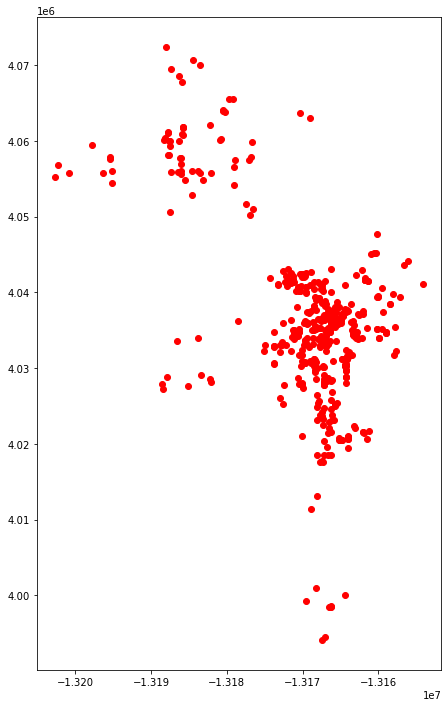

In [128]:
hcid_geo.plot(figsize=(12,12),color='red')

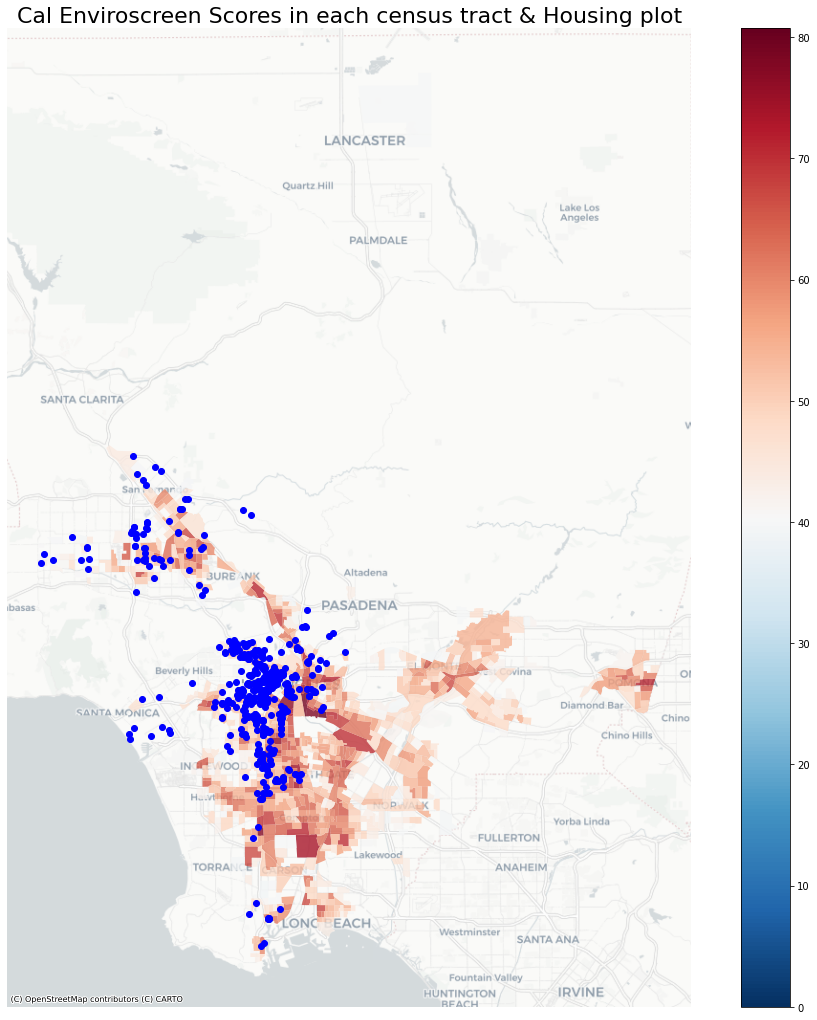

In [129]:
# 


# Now we plot it on a map with a different color gradient
base = combined_sorted.plot(figsize=(18,18),
                        column='Score',
                        legend=True,
                        alpha=0.8,
                        cmap='RdBu_r',    
                        vmin=0,
                    )
ax= hcid_geo.plot(ax=base, figsize=(18,18),color='blue')#creating the base map for the housing dots

ax.axis('off')
ax.set_title('Cal Enviroscreen Scores in each census tract & Housing plot',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)



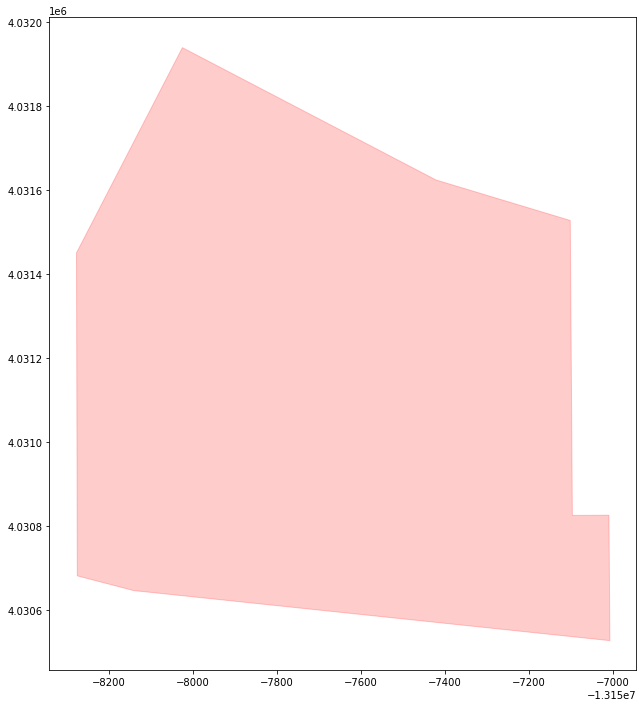

In [130]:
# define the base layer to be the neighborhood polygon
basetract = singledtract.plot(figsize=(12,12),
                             color='red', 
                             edgecolor='red',
                             alpha=0.2)

When we mapped the singled out census tract with the singled out census tract there was no data showing- We assumed that no housing was present in that census tract, but our gdp joined data frame had no rows. After projecting the

In [131]:
# do a spatial join to get affordable housing in census tract
housing_in_tract = gpd.sjoin(hcid_geo,singledtract,how='inner')

housing_in_tract

APN PROJECT NUMBER                       NAME DEVELOPMENT STAGE  \
302  5191012020      12-118877  BESWICK SENIOR APARTMENTS        In-Service   

    CONSTRUCTION TYPE                SITE ADDRESS  SITE  COUNCIL DISTRICT  \
302  NEW CONSTRUCTION  3553 E BESWICK ST CA 90023                      14   

     SITE # SITE COMMUNITY  SITE UNITS  ...  index_right Census Tract  Score  \
302       1  BOYLE HEIGHTS          33  ...          221  06037204920  80.73   

             Percentile Range  Burden Percentile  Characteristcs Percentile  \
302  95-100% (highest scores)              99.88                      94.89   

     Population  California County Approximate Zip Code  Nearby City  
302        2598        Los Angeles                90023  Los Angeles  

[1 rows x 41 columns]

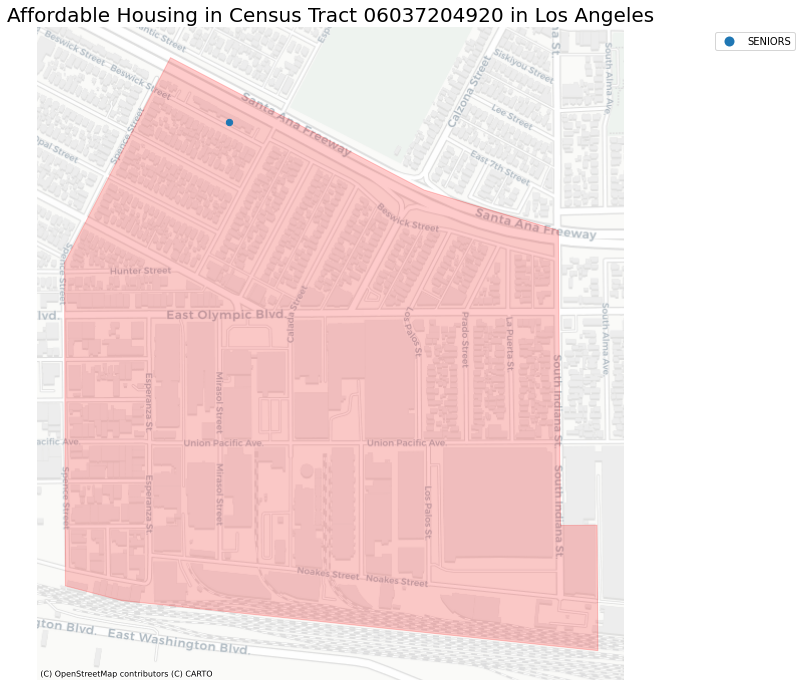

In [132]:
# define the base layer to be the neighborhood polygon
basetract = singledtract.plot(figsize=(12,12),
                             color='red', 
                             edgecolor='red',
                             alpha=0.2)

ax = housing_in_tract.plot(ax=basetract, 
    column='HOUSING TYPE',
    markersize=40, 
    legend=True,
    cmap='tab20',
    legend_kwds={
       'loc': 'upper right',
       'bbox_to_anchor':(1.3,1)
    }                  # this puts the legend to the side
)

# turn off the axis
ax.axis('off')

# add a title
ax.set_title('Affordable Housing in Census Tract '+housing_in_tract['Census Tract'].values[0]+' in Los Angeles',fontsize=20)


# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
ax

## Combining the Housing and the Vulnerabilty score into one function

In [133]:
def map_housing_by_tract(place='06037204920'):
    
    global combined_sorted

    # reproject to web mercator
    combined_sorted = combined_sorted.to_crs(epsg=3857)
      

    # subset the Cal Enviro geodataframe for a single census tract
    singledtract = combined_sorted[combined_sorted['Census Tract']==place]
    
       
    # use the bounding box coordinates to set the x and y limits
    minx, miny, maxx, maxy = singledtract.geometry.total_bounds
    
    # convert pandas dataframe to geodataframe
    hcid_geo = gpd.GeoDataFrame(hcid, 
                         crs='EPSG:4326', #Changed from 4326 
                         geometry=gpd.points_from_xy(hcid['SITE LONGITUDE'], 
                                                     hcid['SITE LATITUDE']))
    # creating a geodata frame and projecting it to EPSG:3857
    hcid_geo = hcid_geo.to_crs('EPSG:3857')
    
    # define the base layer to be the neighborhood polygon
    basetract = singledtract.plot(figsize=(12,12),
                             color='red', 
                             edgecolor='red',
                             alpha=0.2)
    # do a spatial join to get affordable housing in census tract
    housing_in_tract = gpd.sjoin(hcid_geo,singledtract,how='inner')
    
    # define the base layer to be the neighborhood polygon
    basetract = singledtract.plot(figsize=(12,12),
                             color='red', 
                             edgecolor='red',
                             alpha=0.2)

    ax = housing_in_tract.plot(ax=basetract, 
        column='HOUSING TYPE',
        markersize=40, 
        legend=True,
        cmap='tab20',
        legend_kwds={
           'loc': 'upper right',
           'bbox_to_anchor':(1.3,1)
        }                  # this puts the legend to the side
    )

    # turn off the axis
    ax.axis('off')

    # add a title
    ax.set_title('Affordable Housing in Census Tract '+housing_in_tract['Census Tract'].values[0]+' in Los Angeles',fontsize=20)


    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
    ax


<div class="alert alert-danger">
There is some redundant code, so a little clean up is necessary.
    
Also, the error is because the spatial join does not return any HCID records. Add an if statement to capture this.
</div>

In [134]:
#Second function run attempt

def map_housing_by_tract(place='06037204920'):
    
    # subset the Cal Enviro geodataframe for a single census tract
    singledtract = combined_sorted[combined_sorted['Census Tract']==place]
       
    # use the bounding box coordinates to set the x and y limits
    minx, miny, maxx, maxy = singledtract.geometry.total_bounds
    
    # convert pandas dataframe to geodataframe
    hcid_geo = gpd.GeoDataFrame(hcid, 
                         crs='EPSG:4326', #Changed from 4326 
                         geometry=gpd.points_from_xy(hcid['SITE LONGITUDE'], 
                                                     hcid['SITE LATITUDE']))

    # creating a geodata frame and projecting it to EPSG:3857
    hcid_geo = hcid_geo.to_crs('EPSG:3857')
    
    # do a spatial join to get affordable housing in census tract
    housing_in_tract = gpd.sjoin(hcid_geo,singledtract,how='inner')

    # only draw a map if it returns more than one record
    if len(housing_in_tract)> 0:
        # define the base layer to be the neighborhood polygon
        basetract = singledtract.plot(figsize=(12,12),
                                 color='red', 
                                 edgecolor='red',
                                 alpha=0.2)

        ax = housing_in_tract.plot(ax=basetract, 
            column='HOUSING TYPE',
            markersize=40, 
            legend=True,
            cmap='tab20',
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1.3,1)
            }                  # this puts the legend to the side
        )

        # turn off the axis
        ax.axis('off')

        # add a title
        ax.set_title('Affordable Housing in Census Tract '+housing_in_tract['Census Tract'].values[0]+' in Los Angeles',fontsize=20)


        # add a basemap
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
        ax
    
    # no records found
    else:
        print('No records found.')
        


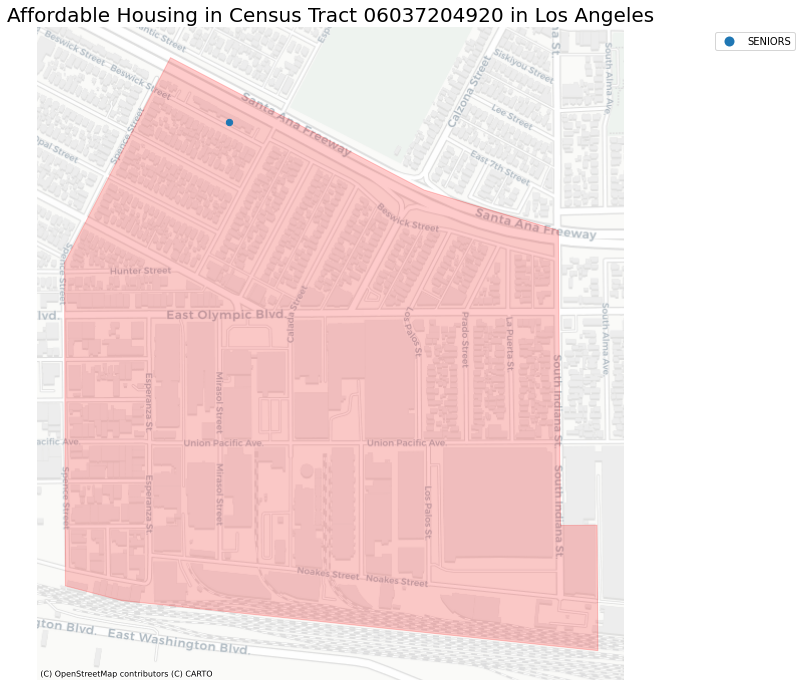

In [135]:
# call the function!
map_housing_by_tract(place='06037204920')

In [136]:
# call the function!
map_housing_by_tract(place='06037291220')

No records found.


## Trying our function with the census tracts with the highest CalEnviro Score

We run this function for all of the top 10 census tracts, and only one of them showed a housing project withing its boundary. This leads to our preliminary conclusion that not sufficient affordable housing is being built in the top most vulnerable census tracts.

In [137]:
# Highest score census tract at 99.04
map_housing_by_tract(place='06019001100')

No records found.


In [138]:
# Highest score census tract at 94.90
map_housing_by_tract(place='06071001600')

No records found.


In [139]:
# Highest score census tract at 85.97
map_housing_by_tract(place='06019000200')

No records found.


In [140]:
# Highest score census tract at 85.97
map_housing_by_tract(place='06077000801')

No records found.


In [141]:
# Highest score census tract at 82.03
map_housing_by_tract(place='06019001500')

No records found.


In [142]:
# Highest score census tract at 80.18
map_housing_by_tract(place='06077000300')

No records found.


In [143]:
# Highest score census tract at 80.13
map_housing_by_tract(place='06019001000')

No records found.


In [144]:
# Highest score census tract at 79.03
map_housing_by_tract(place='06037206050')

No records found.


In [145]:
# Highest score census tract at 78.53
map_housing_by_tract(place='06019000400')

No records found.


## Testing this function with a random census tract
We run one other random census tract and it shows one senior project and one family project. With this random run test, we know that the function is working, but only with the census tracts that do have at least one affordable housing project. 

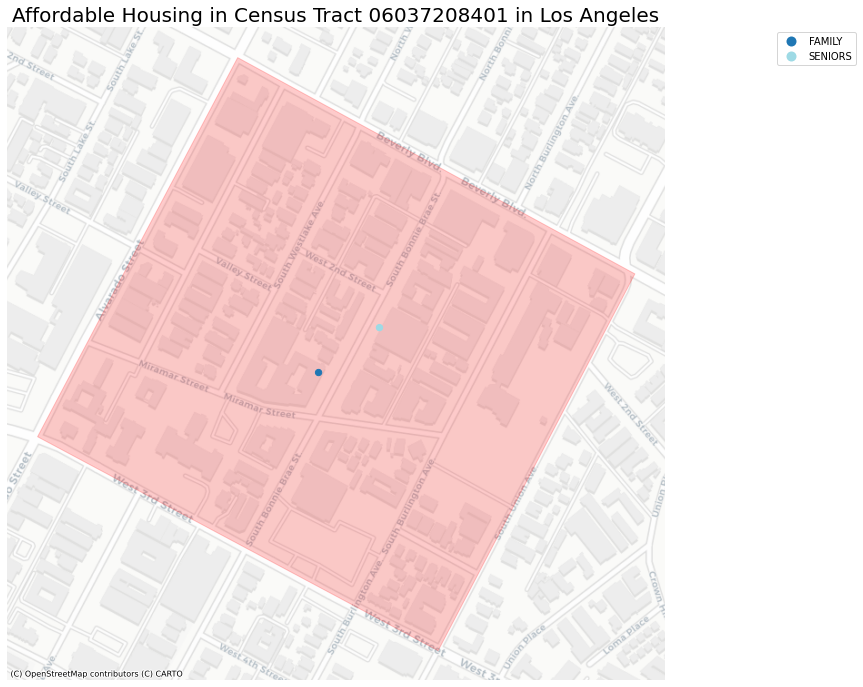

In [146]:
# random census tract in the Westlake area
map_housing_by_tract(place='06037208401')



# Overlaying housing and Cal Envrio Maps

Now we create a full size map showing the location of the affordable housing projects overlaid on the CalEnviro Screen scores map.

In [147]:
# get the bounding box coordinates for housing data
minx, miny, maxx, maxy = hcid_geo.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)


-13202690.869970765
-13154095.45945987
3994090.834414092
4072393.420646349


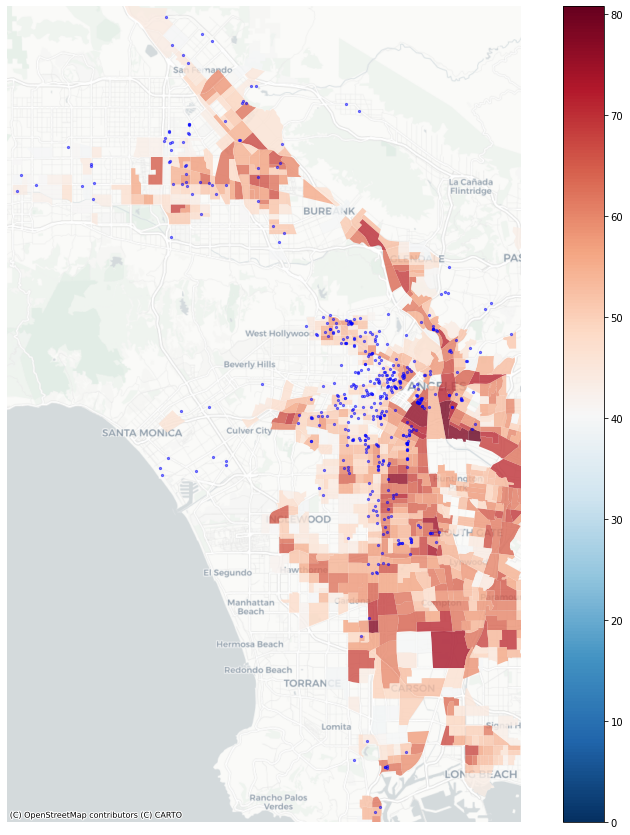

In [148]:
# set up the plot canvas with plt.subplots - DEFINE THE PLOT FIRST  in terms of size, and once it defines the axis, we can tell the map to go into that axis. 
fig, ax = plt.subplots(figsize=(15, 15))

# block groups - instead of two graphics, we put it on top of each other. 
combined_sorted.plot(ax=ax, # this puts it in the ax plot
         column='Score',
                        legend=True,
                        alpha=0.8,
                        cmap='RdBu_r',    
                        vmin=0) 
# arrests
hcid_geo.plot(ax=ax, # this also puts it in the same ax plot
            color='blue',
            markersize=5,
            alpha=0.5)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [149]:
hcid_geo.head()

APN PROJECT NUMBER                                NAME  \
0  5131020009      05-117217  LEXINGTON APARTMENTS A/B (SITE 11)   
1  5067008008      06-117222        WINDWARD APTS (A/B) (SITE 4)   
2  5108021026      13-120914  JUANITA TATE LEGACY TOWERS (RECAP)   
3  5058024017          20289          LA 78 PRESERVATION PROJECT   
4  2218023009      12-119044      HAZELTINE & WYANDOTTE (SITE 2)   

  DEVELOPMENT STAGE    CONSTRUCTION TYPE  \
0        In-Service                REHAB   
1        In-Service                REHAB   
2        In-Service  ACQUISITION + REHAB   
3        In-Service                  NaN   
4        In-Service  ACQUISITION + REHAB   

                               SITE ADDRESS  SITE  COUNCIL DISTRICT  SITE #  \
0                   1145 E 24TH ST CA 90011                       9      11   
1                 4817 W SATURN ST CA 90019                      10       4   
2         4827 S CENTRAL AVE 1-118 CA 90011                       9       1   
3                   1951 W 22ND ST CA 90018                       8       1   
4  14630 W WYANDOTTE ST  VAN NUYS, CA 91405                       6       2   

    SITE COMMUNITY  SITE UNITS  ...   CONTACT PHONE  \
0          CENTRAL           0  ...  (323) 231-4174   
1  ST ELMO VILLAGE           6  ...  (323) 231-4174   
2   VERNON CENTRAL         118  ...             NaN   
3       WEST ADAMS          20  ...  (602) 350-2931   
4         VAN NUYS          73  ...  (818) 789-5550   

                                               PHOTO  JOBS  \
0  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
1  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
2  click here (http://hcidapp.lacity.org/mpphotos...  92.0   
3  click here (http://hcidapp.lacity.org/mpphotos...   NaN   
4  click here (http://hcidapp.lacity.org/mpphotos...  41.0   

                                 PROJECT SUMMARY URL  CONTRACT NUMBERS  \
0  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
1  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
2  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
3  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   
4  click here (http://hcidapp.lacity.org/ahtfRepo...               NaN   

               DATE STAMP  SITE LONGITUDE  SITE LATITUDE  \
0  09/09/2020 12:00:00 AM      -118.25561       34.02133   
1  09/09/2020 12:00:00 AM      -118.34217       34.04429   
2  09/09/2020 12:00:00 AM      -118.25668       33.99978   
3  09/09/2020 12:00:00 AM      -118.30509       34.03651   
4  09/09/2020 12:00:00 AM      -118.45222       34.20289   

                      GPS_COORDS ON MAP                           geometry  
0  POINT (-118.25561000000002 34.02133)  POINT (-13164154.289 4031666.484)  
1           POINT (-118.34217 34.04429)  POINT (-13173790.104 4034750.643)  
2  POINT (-118.25668 33.99978000000001)  POINT (-13164273.401 4028772.486)  
3  POINT (-118.30509000000002 34.03651)  POINT (-13169662.377 4033705.481)  
4  POINT (-118.45222000000001 34.20289)  POINT (-13186040.814 4056077.840)  

[5 rows x 31 columns]

In [150]:
# Do the spatial join ' this requires 3 data frames, the df you want data from, to. gfd is census groups. so we can summarize the arrests by cencus groups.'
join = gpd.sjoin(combined_sorted, hcid_geo,how='right')
join.head()

index_left Census Tract  Score          Percentile Range  \
302       221.0  06037204920  80.73  95-100% (highest scores)   
242       409.0  06037239202  76.04  95-100% (highest scores)   
303       778.0  06037535400  74.46  95-100% (highest scores)   
184       216.0  06037204600  73.13  95-100% (highest scores)   
374       216.0  06037204600  73.13  95-100% (highest scores)   

     Burden Percentile  Characteristcs Percentile  Population  \
302              99.88                      94.89      2598.0   
242              96.91                      99.23      4724.0   
303              97.41                      97.96      3495.0   
184              98.53                      94.83      4101.0   
374              98.53                      94.83      4101.0   

    California County  Approximate Zip Code  Nearby City  ...   CONTACT PHONE  \
302       Los Angeles               90023.0  Los Angeles  ...  (213) 787-2700   
242       Los Angeles               90001.0  Los Angeles  ...             NaN   
303       Los Angeles               90002.0  Los Angeles  ...  (209) 334-6565   
184       Los Angeles               90023.0  Los Angeles  ...  (916) 850-4465   
374       Los Angeles               90023.0  Los Angeles  ...  (949) 748-8204   

                                                 PHOTO   JOBS  \
302  click here (http://hcidapp.lacity.org/mpphotos...   93.0   
242  click here (http://hcidapp.lacity.org/mpphotos...   92.0   
303  click here (http://hcidapp.lacity.org/mpphotos...    NaN   
184  click here (http://hcidapp.lacity.org/mpphotos...  295.0   
374  click here (http://hcidapp.lacity.org/mpphotos...  218.0   

                                   PROJECT SUMMARY URL  \
302  click here (http://hcidapp.lacity.org/ahtfRepo...   
242  click here (http://hcidapp.lacity.org/ahtfRepo...   
303  click here (http://hcidapp.lacity.org/ahtfRepo...   
184  click here (http://hcidapp.lacity.org/ahtfRepo...   
374  click here (http://hcidapp.lacity.org/ahtfRepo...   

                                      CONTRACT NUMBERS  \
302  C-121979 (https://hcidapp.lacity.org/citycontr...   
242  C-108434 (https://hcidapp.lacity.org/citycontr...   
303                                                NaN   
184  C-122710 (https://hcidapp.lacity.org/citycontr...   
374  C-123417 (https://hcidapp.lacity.org/citycontr...   

                 DATE STAMP  SITE LONGITUDE  SITE LATITUDE  \
302  09/09/2020 12:00:00 AM      -118.19931       34.02223   
242  09/09/2020 12:00:00 AM      -118.27346       33.98525   
303  09/09/2020 12:00:00 AM      -118.22890       33.94670   
184  09/09/2020 12:00:00 AM      -118.21750       34.03863   
374  09/09/2020 12:00:00 AM      -118.21750       34.03863   

                        GPS_COORDS ON MAP                           geometry  
302           POINT (-118.19931 34.02223)  POINT (-13157887.001 4031787.363)  
242  POINT (-118.27346000000001 33.98525)  POINT (-13166141.342 4026821.633)  
303             POINT (-118.2289 33.9467)  POINT (-13161180.945 4021647.382)  
184  POINT (-118.21750000000002 34.03863)  POINT (-13159911.903 4033990.272)  
374  POINT (-118.21750000000002 34.03863)  POINT (-13159911.903 4033990.272)  

[5 rows x 41 columns]

Earlier, we joined housing projects to individual census tracts that we manually selected. Now we are counting up all of the affordable housing projects in each tract

In [151]:
housing_by_all_tracts = join['Census Tract'].value_counts().rename_axis('Census Tract').reset_index(name='housing_count')

In [152]:
housing_by_all_tracts.head()

Census Tract  housing_count
0  06037206300             16
1  06037209102              8
2  06037224420              7
3  06037231220              7
4  06037187102              7

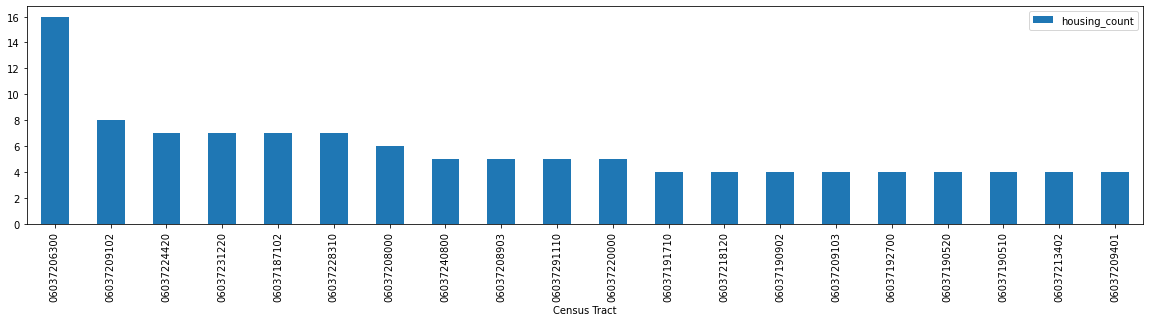

In [153]:
housing_by_all_tracts[:20].plot.bar(figsize=(20,4),
                             x='Census Tract',
                             y='housing_count')

# join value counts back to our main geo data frame

Now that we have the total number of projects in each census tract we add this number back to the main data frame using Census Tract as the common column. 

In [154]:
# join the summary table back to the gdf
combined_sorted=combined_sorted.merge(housing_by_all_tracts,on='Census Tract')

In [155]:
combined_sorted.head(50)

Census Tract                                           geometry  Score  \
0   06037204920  MULTIPOLYGON (((-13158276.842 4030683.113, -13...  80.73   
1   06037239202  MULTIPOLYGON (((-13166193.439 4026564.006, -13...  76.04   
2   06037535400  MULTIPOLYGON (((-13162778.936 4022534.153, -13...  74.46   
3   06037204600  MULTIPOLYGON (((-13160234.952 4032801.051, -13...  73.13   
4   06037227010  MULTIPOLYGON (((-13164028.052 4031471.468, -13...  72.68   
5   06037206032  MULTIPOLYGON (((-13161302.061 4035236.716, -13...  71.56   
6   06037226001  MULTIPOLYGON (((-13164949.889 4032522.469, -13...  71.53   
7   06037239501  MULTIPOLYGON (((-13165704.635 4025063.601, -13...  71.36   
8   06037291210  MULTIPOLYGON (((-13168128.172 4012994.909, -13...  69.62   
9   06037242100  MULTIPOLYGON (((-13162054.692 4021277.019, -13...  68.88   
10  06037229420  MULTIPOLYGON (((-13165220.173 4027372.618, -13...  68.25   
11  06037239601  MULTIPOLYGON (((-13166948.631 4025400.662, -13...  67.30   
12  06037122410  MULTIPOLYGON (((-13179828.964 4055872.446, -13...  66.93   
13  06037239702  MULTIPOLYGON (((-13166948.185 4023450.654, -13...  66.87   
14  06037122122  MULTIPOLYGON (((-13177895.455 4058647.740, -13...  66.51   
15  06037242600  MULTIPOLYGON (((-13164003.117 4019536.209, -13...  66.48   
16  06037206300  MULTIPOLYGON (((-13163575.650 4034612.267, -13...  65.94   
17  06037206200  MULTIPOLYGON (((-13163259.280 4034988.974, -13...  65.26   
18  06037239602  MULTIPOLYGON (((-13166949.187 4024881.048, -13...  64.92   
19  06037127104  MULTIPOLYGON (((-13184679.822 4056338.156, -13...  63.75   
20  06037240500  MULTIPOLYGON (((-13166843.100 4021139.479, -13...  63.49   
21  06037219800  MULTIPOLYGON (((-13175604.500 4032443.087, -13...  63.22   
22  06037296210  MULTIPOLYGON (((-13167745.567 3994626.858, -13...  62.31   
23  06037104703  MULTIPOLYGON (((-13181261.089 4063002.997, -13...  62.25   
24  06037239310  MULTIPOLYGON (((-13166948.074 4025957.484, -13...  62.24   
25  06037229300  MULTIPOLYGON (((-13166195.888 4028207.335, -13...  62.20   
26  06037224010  MULTIPOLYGON (((-13166187.873 4033936.940, -13...  62.14   
27  06037294900  MULTIPOLYGON (((-13166991.043 3997799.067, -13...  62.08   
28  06037208000  MULTIPOLYGON (((-13164820.536 4036632.846, -13...  61.81   
29  06037199000  MULTIPOLYGON (((-13160784.759 4038783.607, -13...  61.19   
30  06037187102  MULTIPOLYGON (((-13164832.558 4043554.761, -13...  61.18   
31  06037232500  MULTIPOLYGON (((-13171002.330 4027518.155, -13...  61.01   
32  06037240200  MULTIPOLYGON (((-13166903.323 4022465.174, -13...  60.81   
33  06037204910  MULTIPOLYGON (((-13158026.485 4031941.284, -13...  60.12   
34  06037241120  MULTIPOLYGON (((-13166869.816 4019558.615, -13...  59.67   
35  06037242300  MULTIPOLYGON (((-13163432.493 4021320.630, -13...  59.66   
36  06037231720  MULTIPOLYGON (((-13167663.302 4029421.590, -13...  59.28   
37  06037191810  MULTIPOLYGON (((-13172786.559 4040587.173, -13...  59.18   
38  06037227020  MULTIPOLYGON (((-13164254.699 4030656.522, -13...  59.12   
39  06037229200  MULTIPOLYGON (((-13165222.622 4028342.410, -13...  58.69   
40  06037127220  MULTIPOLYGON (((-13186624.017 4055864.505, -13...  58.66   
41  06037192700  MULTIPOLYGON (((-13168170.696 4039238.672, -13...  58.57   
42  06037232120  MULTIPOLYGON (((-13167663.079 4028324.552, -13...  58.51   
43  06037208302  MULTIPOLYGON (((-13165243.439 4037082.719, -13...  58.14   
44  06037219300  MULTIPOLYGON (((-13173002.964 4032029.930, -13...  58.07   
45  06037206010  MULTIPOLYGON (((-13162331.543 4037836.577, -13...  58.06   
46  06037190801  MULTIPOLYGON (((-13172059.976 4041114.359, -13...  58.06   
47  06037190510  MULTIPOLYGON (((-13170957.023 4042464.023, -13...  57.97   
48  06037243000  MULTIPOLYGON (((-13162307.944 4020465.887, -13...  57.76   
49  06037240900  MULTIPOLYGON (((-13165702.297 4019676.951, -13...  57.54   

            Percentile Range  Burden Percentile  Characteristcs Percentile 

/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:235: UserWarning:


/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning:




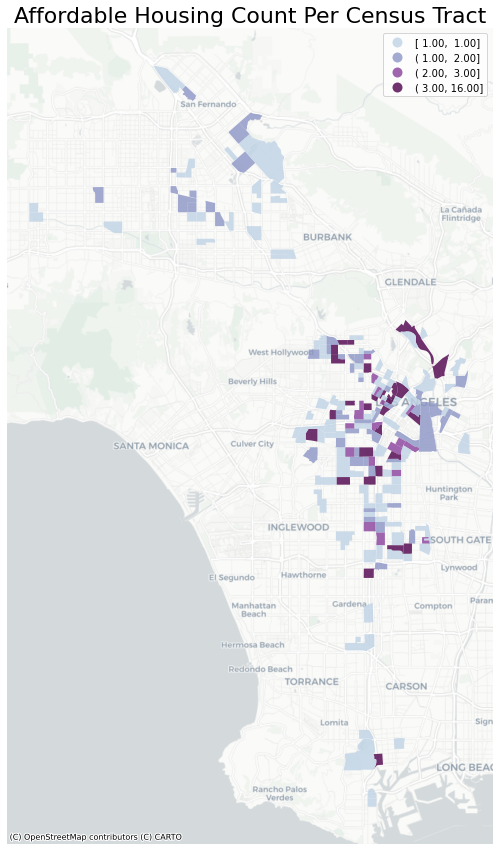

In [156]:
ax = combined_sorted.plot(figsize=(15,15),
                        column='housing_count',
                        legend=True,
                        alpha=0.8,
                        cmap='BuPu',
                        scheme='quantiles',
                        vmin=-1)

ax.axis('off')
ax.set_title('Affordable Housing Count Per Census Tract',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This map is starting to look interesting! We can see some darker clusters of census tracts appearing. We did notice that there are other affordable housing projects on the west side in our earlier map that don't show up at all in this map. Eventually we realized that it's because none of those census tracts are in our CalEnviroScreen tracts so they aren't picking up here. But this is ok since we are interested in the housing in the census tracts with higher scores.

One thing to note is the error above mentions that there aren't enough values to form the K class. Maybe it's because our data set is smaller than something like the arrest data? 

# Spatial Auto Correlation

Now we attempt to do a spatial auto correlation. It seems to work for the most part but we get a user warning below saying there are 2 disconnected components. We're not sure what that means but it doesn't seem to prevent us from continuing forward so we'll keep going.

In [157]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(combined_sorted,k=8)
wq.transform = 'r'

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



In [158]:
# create a new column for the spatial lag
combined_sorted['housing_count_lag'] = lps.weights.lag_spatial(wq,combined_sorted['housing_count'])


In [159]:
combined_sorted.sort_values(by='housing_count',ascending=False).sample(50)


Census Tract                                           geometry  Score  \
149  06037218800  MULTIPOLYGON (((-13172254.897 4033543.879, -13...  47.02   
158  06037211202  MULTIPOLYGON (((-13168712.488 4039052.665, -13...  45.82   
131  06037104821  MULTIPOLYGON (((-13182750.655 4062399.377, -13...  48.63   
120  06037237500  MULTIPOLYGON (((-13168154.889 4025512.480, -13...  49.38   
204  06037207400  MULTIPOLYGON (((-13163900.814 4036677.994, -13...    NaN   
2    06037535400  MULTIPOLYGON (((-13162778.936 4022534.153, -13...  74.46   
156  06037121102  MULTIPOLYGON (((-13180559.331 4062201.544, -13...  46.14   
151  06037209401  MULTIPOLYGON (((-13167339.696 4036436.133, -13...  46.85   
201  06037134522  MULTIPOLYGON (((-13203143.161 4055952.261, -13...  39.97   
110  06037122120  MULTIPOLYGON (((-13177895.901 4056948.453, -13...  50.69   
183  06037132700  MULTIPOLYGON (((-13195370.389 4054366.019, -13...  43.24   
12   06037122410  MULTIPOLYGON (((-13179828.964 4055872.446, -13...  66.93   
154  06037208720  MULTIPOLYGON (((-13167336.690 4036833.459, -13...  46.47   
189  06037208620  MULTIPOLYGON (((-13166998.279 4038116.498, -13...  42.53   
8    06037291210  MULTIPOLYGON (((-13168128.172 4012994.909, -13...  69.62   
93   06037231600  MULTIPOLYGON (((-13169601.708 4029617.779, -13...  52.79   
109  06037210010  MULTIPOLYGON (((-13166521.498 4034795.514, -13...  50.75   
22   06037296210  MULTIPOLYGON (((-13167745.567 3994626.858, -13...  62.31   
98   06037209102  MULTIPOLYGON (((-13165883.192 4036040.971, -13...  52.00   
187  06037221220  MULTIPOLYGON (((-13169136.615 4034182.643, -13...  42.62   
32   06037240200  MULTIPOLYGON (((-13166903.323 4022465.174, -13...  60.81   
163  06037222001  MULTIPOLYGON (((-13171059.993 4032356.854, -13...  45.54   
135  06037191410  MULTIPOLYGON (((-13168174.481 4040584.216, -13...  48.04   
155  06037237720  MULTIPOLYGON (((-13168165.909 4024611.384, -13...  46.22   
9    06037242100  MULTIPOLYGON (((-13162054.692 4021277.019, -13...  68.88   
184  06037191203  MULTIPOLYGON (((-13168662.060 4041352.689, -13...  43.21   
61   06037228210  MULTIPOLYGON (((-13164252.138 4029814.777, -13...  56.02   
106  06037218120  MULTIPOLYGON (((-13171728.244 4034416.798, -13...  51.17   
13   06037239702  MULTIPOLYGON (((-13166948.185 4023450.654, -13...  66.87   
26   06037224010  MULTIPOLYGON (((-13166187.873 4033936.940, -13...  62.14   
105  06037220000  MULTIPOLYGON (((-13174220.354 4032231.940, -13...  51.17   
1    06037239202  MULTIPOLYGON (((-13166193.439 4026564.006, -13...  76.04   
152  06037231210  MULTIPOLYGON (((-13169114.908 4030424.728, -13...  46.77   
86   06037231100  MULTIPOLYGON (((-13167174.943 4030642.421, -13...  53.31   
70   06037204420  MULTIPOLYGON (((-13159685.034 4034478.730, -13...  54.72   
69   06037187200  MULTIPOLYGON (((-13164330.062 4043249.833, -13...  54.95   
21   06037219800  MULTIPOLYGON (((-13175604.500 4032443.087, -13...  63.22   
100  06037125320  MULTIPOLYGON (((-13177886.661 4051038.672, -13...  51.63   
40   06037127220  MULTIPOLYGON (((-13186624.017 4055864.505, -13...  58.66   
142  06037127910  MULTIPOLYGON (((-13185651.307 4055036.639, -13...  47.43   
42   06037232120  MULTIPOLYGON (((-13167663.079 4028324.552, -13...  58.51   
95   06037191720  MULTIPOLYGON (((-13170847.039 4040995.263, -13...  52.10   
55   06037226700  MULTIPOLYGON (((-13165690.609 4031110.322, -13...  56.78   
134  06037221302  MULTIPOLYGON (((-13171066.227 4034295.757, -13...  48.15   
101  06037231900  MULTIPOLYGON (((-13166923.918 4028330.594, -13...  51.50   
160  06037208802  MULTIPOLYGON (((-13167027.111 4036929.400, -13...  45.74   
34   06037241120  MULTIPOLYGON (((-13166869.816 4019558.615, -13...  59.67   
15   06037242600  MULTIPOLYGON (((-13164003.117 4019536.209, -13...  66.48   
16   06037206300  MULTIPOLYGON (((-13163575.650 4034612.267, -13...  65.94   
177  06037117405  MULTIPOLYGON (((-13188350.137 4060046.211, -13...  43.70   

             Percentile R

# Spatial Lag Map

And finally now we map the spatial lag. It looks like downtown has quite a high lag compared to the rest of the city which seems in line with what we could guess by looking at the original map. We added the actual locations of the housing projects to the map as well to see how they lined up.


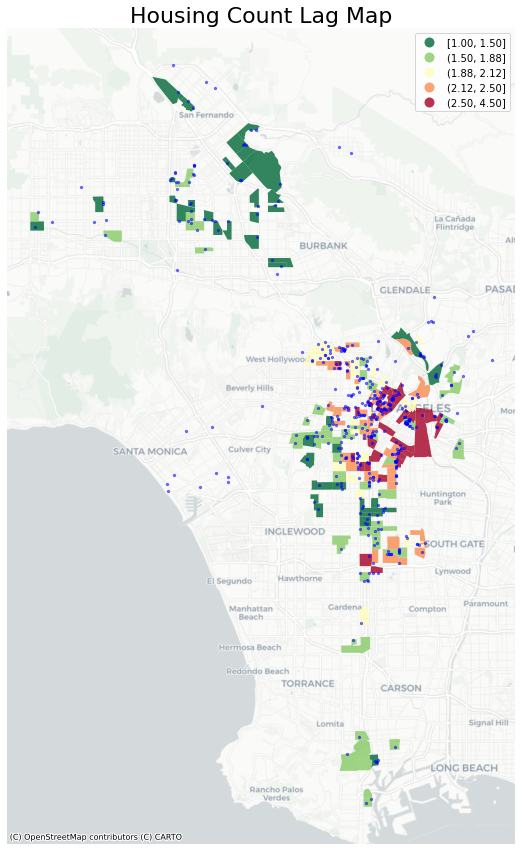

In [160]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
combined_sorted.plot(ax=ax,
         figsize=(15,15),
         column='housing_count_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

# add actual point locations of housing
hcid_geo.plot(ax=ax, 
              color='blue',
              markersize =5,
              alpha=0.5, 
              legend=True)

ax.axis('off')
ax.set_title('Housing Count Lag Map',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:235: UserWarning:


/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning:




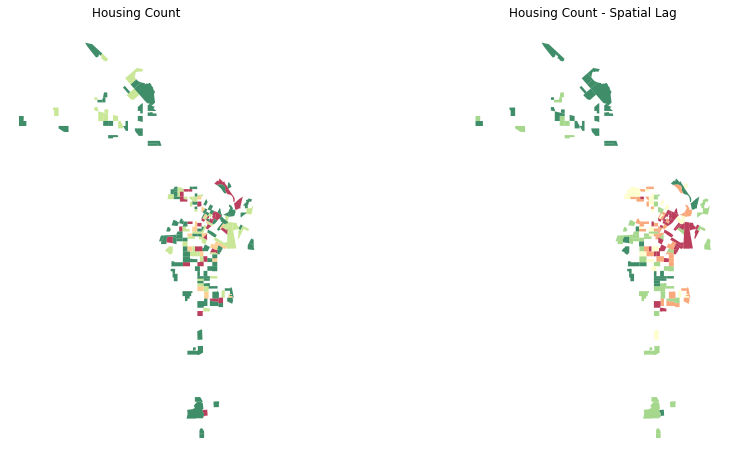

In [161]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
combined_sorted.plot(column='housing_count', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax1 # this assigns the map to the subplot
           )


ax1.axis("off")
ax1.set_title("Housing Count")

# spatial lag map on the right
combined_sorted.plot(column='housing_count_lag', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax2 # this assigns the map to the subplot
           )

ax2.axis("off")
ax2.set_title("Housing Count - Spatial Lag")

plt.show()

Here we showed them side by side, but again with this k class error, it's not clear if this is a totally accurate visualization of the clustering. But it looks like there is a strong clustering downtown.

# Interactive spatial lag

In this section we joined the combined_sorted and the housing_count data frame lag with the javascript interactive base map using the choropleth_mapbox.

The map shows the census tracts with the highest concentration of housing projects that have also a enviro screen score. 

We added a couple of labels to the hover data option including: the number of units, the Cal Enviro Score of that census tract and the lag index score. We observed that some of the census tracts that have the highest housing number and lag score do not necessarily have a high CalEnviro Score, meaning the housing is not located in the most vulnerable areas. 

In [162]:
# interactive version needs to be in WGS84
gdf_web = combined_sorted.to_crs('EPSG:4326')

In [163]:
# what's the centroid?
minx, miny, maxx, maxy = gdf_web.geometry.total_bounds
center_lat_gdf_web = (maxy-miny)/2+miny
center_lon_gdf_web = (maxx-minx)/2+minx

In [164]:
# some statistics
gdf_web.housing_count_lag.describe()

count    206.000000
mean       2.072209
std        0.648301
min        1.000000
25%        1.625000
50%        2.000000
75%        2.375000
max        4.500000
Name: housing_count_lag, dtype: float64

In [165]:
# grab the median
median = gdf_web.housing_count_lag.median()

In [166]:
# set the mapbox access token
token = 'pk.eyJ1IjoieW9obWFuIiwiYSI6IkxuRThfNFkifQ.u2xRJMiChx914U7mOZMiZw'
px.set_mapbox_access_token(token)

We still want to confirm what the lag map represents, but we are glad we were able to get it to display properly

In [167]:
fig = px.choropleth_mapbox(gdf_web, 
                     geojson=gdf_web.geometry, 
                     locations=gdf_web.index, 
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='housing_count_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median,
                     range_color =(0,median*2),
                     hover_data=['housing_count','Score','housing_count_lag'],
                     center = {"lat": center_lat_gdf_web, "lon": center_lon_gdf_web},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     labels={
                             'housing_count_lag':'Affordable Housing Count (Spatial Lag)',
                             'housing_count':'Affordable Housing Count',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Moran's Plot

This would be our first test to quantify the spatial correlation between the housing project location and the census tract score. 
Our Moran I ratio is positive, but low, and our range is fairly small as well as displayed on the Moran Scatterplot figure. 

There is a very extreme outlier in the scatter plot; which may affect the distribution


In [168]:
y = combined_sorted.housing_count
moran = Moran(y, wq)
moran.I

0.021617581698798315

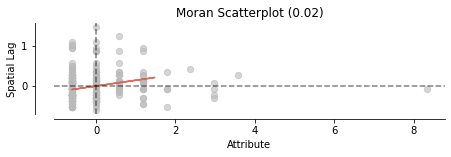

In [75]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.



(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5d473032b0>)

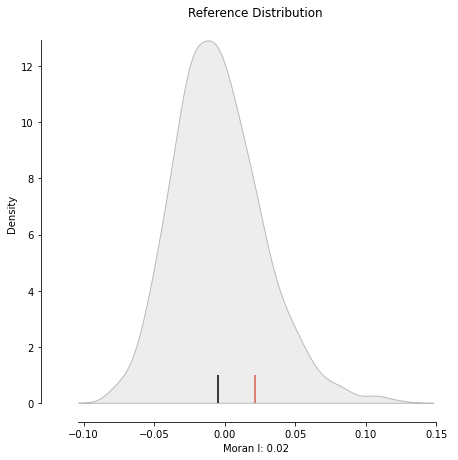

In [76]:
plot_moran_simulation(moran,aspect_equal=False)

In [77]:
moran.p_sim

0.185

We have gotten a high p-value of 0.185

# Local spatial Autocorrelation

Using Local Indicators of Spatial Association (LISA) we are going to visualize where the clusters of high and low association are between housing projects and the lag index as follows: 
* HH: High lag value & High housing count values
* LL: Low lag value & Low housing count values
* LH: Low lag value & high housing count values
* HL: High lag value & low housing count


-We are still understanding this concepts, so feedback is appreciated



In [169]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

In the scatterplot we see that only a few census tracts have statistical significance or are spatially autocorrelated

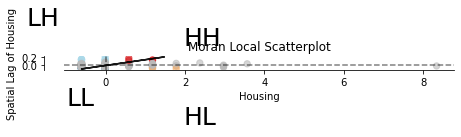

In [79]:
# Plot
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel("Housing")
ax.set_ylabel('Spatial Lag of Housing')
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

The map allows us to see more clearly those census tracts that we find significant with 95% confidence. All of the high values are concentrated in Downtown Los Angeles in four census tracts, all of which have at least 1 project built, and a lag value of over 3.5 
(We know this because of the hover interactive map)

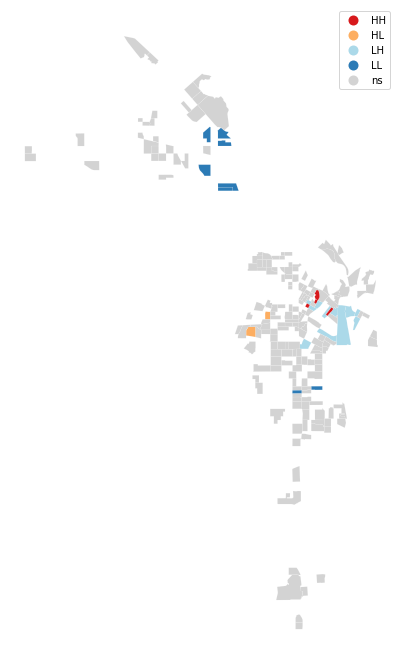

In [80]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, combined_sorted, p=0.05, ax=ax)
plt.show()

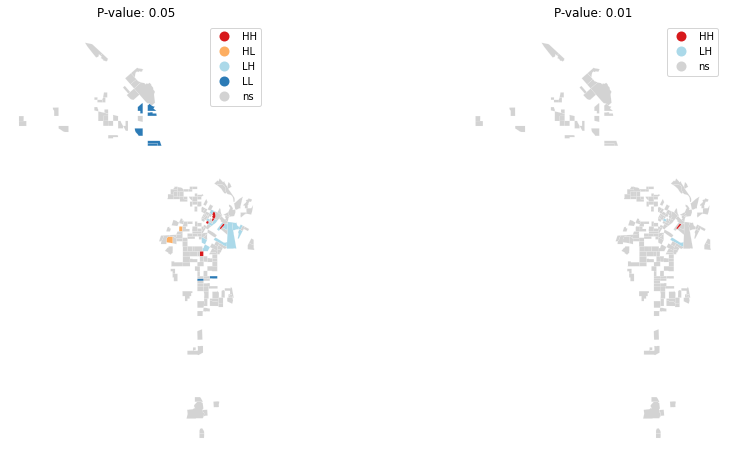

In [170]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
lisa_cluster(lisa, combined_sorted, p=0.05, ax=ax1)

ax1.axis("off")
ax1.set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa,  combined_sorted, p=0.01, ax=ax2)

ax2.axis("off")
ax2.set_title("P-value: 0.01")

plt.show()

# Interactive version of the LISA map

In [82]:
# original value list
lisa.y[:5]

array([1, 1, 1, 2, 3])

In [83]:
# quadrant list
lisa.q[:5]

array([3, 3, 2, 2, 1])

In [84]:
# p sim list
lisa.p_sim[:5]

array([0.38 , 0.363, 0.277, 0.038, 0.161])

In [85]:
# add quadrant numbers to the dataframe
combined_sorted['q'] = lisa.q.tolist()

In [86]:
# add individual p-values to the dataframe
combined_sorted['p_sim'] = lisa.p_sim.tolist()

In [87]:
combined_sorted.head()

Census Tract                                           geometry  Score  \
0  06037204920  MULTIPOLYGON (((-13158276.842 4030683.113, -13...  80.73   
1  06037239202  MULTIPOLYGON (((-13166193.439 4026564.006, -13...  76.04   
2  06037535400  MULTIPOLYGON (((-13162778.936 4022534.153, -13...  74.46   
3  06037204600  MULTIPOLYGON (((-13160234.952 4032801.051, -13...  73.13   
4  06037227010  MULTIPOLYGON (((-13164028.052 4031471.468, -13...  72.68   

           Percentile Range  Burden Percentile  Characteristcs Percentile  \
0  95-100% (highest scores)              99.88                      94.89   
1  95-100% (highest scores)              96.91                      99.23   
2  95-100% (highest scores)              97.41                      97.96   
3  95-100% (highest scores)              98.53                      94.83   
4  95-100% (highest scores)              98.68                      93.77   

   Population California County  Approximate Zip Code  Nearby City  \
0        2598       Los Angeles                 90023  Los Angeles   
1        4724       Los Angeles                 90001  Los Angeles   
2        3495       Los Angeles                 90002  Los Angeles   
3        4101       Los Angeles                 90023  Los Angeles   
4        4662       Los Angeles                 90011  Los Angeles   

   housing_count  housing_count_lag  q  p_sim  
0              1              1.875  3  0.380  
1              1              1.750  3  0.363  
2              1              2.250  2  0.277  
3              2              3.500  2  0.038  
4              3              2.625  1  0.161

# Interactive Hotspot map 

This map basically isolates the High High value census tracts. 
We wonder why some of them are classified as high-high considering that two of this only have one housing count project. 

First we isolate and create a basic map by creating a new data frame that will be shown on the LISA interactive map. 

In [88]:
# identify just the hotspot geographies
hot_spots = combined_sorted[(combined_sorted.p_sim < 0.05) & (combined_sorted.q == 1)]

In [89]:
hot_spots.shape

(4, 14)

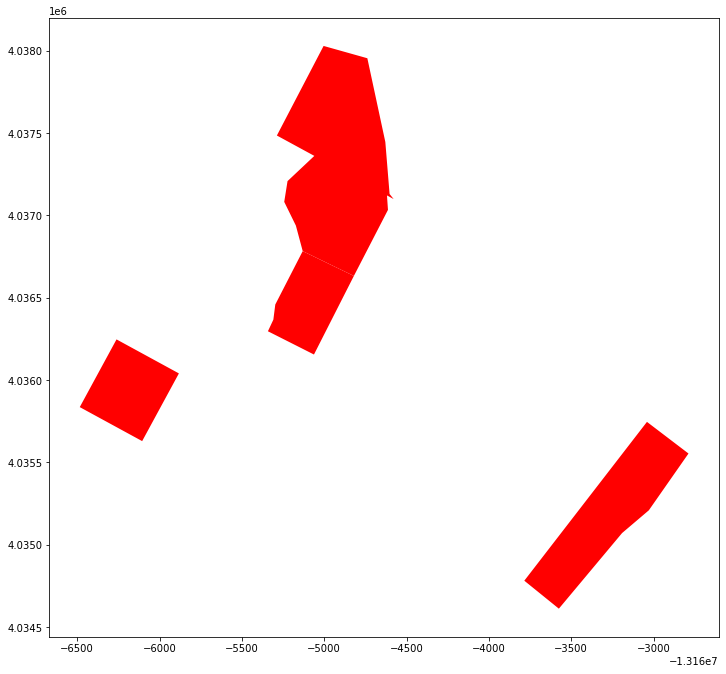

In [90]:
# quick plot... not very informative
hot_spots.plot(figsize=(12,12),color='red',legend=True,categorical=True)

In [91]:
# interactive version needs to be in WGS84
hot_spots = hot_spots.to_crs('EPSG:4326')

In [92]:
# what's the centroid?
minx, miny, maxx, maxy = hot_spots.geometry.total_bounds
center_lat_hot_spots = (maxy-miny)/2+miny
center_lon_hot_spots = (maxx-minx)/2+minx

In [171]:
fig = px.choropleth_mapbox(hot_spots, 
                     geojson=hot_spots.geometry, 
                     locations=hot_spots.index, 
                     mapbox_style="satellite-streets",
                     center = {"lat": center_lat_hot_spots, "lon": center_lon_hot_spots},
                     zoom=12, 
                     opacity=0.6,
                     color='housing_count_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median,
                     range_color =(0,median*2),
                     hover_data=['housing_count','Score','housing_count_lag', 'Census Tract'],
                     labels={
                             'housing_count_lag':'Affordable Housing Count (Spatial Lag)',
                             'housing_count':'Affordable Housing Count',
                             'Score':'CalEnviro Score',
                             'Census Tract':'Census Tract',
                     })
fig.update_traces(marker_line_width=1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Group stats

- We worked on the additional steps (section 7 to the end) together while screen sharing
- Laura drove the first half and added comments to the second half
- Jayne drove the second half and added comments to the first half